In [1]:
# import package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# read data
data = pd.read_csv('../input/dataset-of-songs-in-spotify/genres_v2.csv')
data2 = pd.read_csv('../input/dataset-of-songs-in-spotify/genres_v2.csv')
#data.head(10)

# Delete unimportant features
data.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'song_name', 'Unnamed: 0', 'title'],axis=1, inplace=True)
# data.head(10)
data2.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'song_name', 'Unnamed: 0', 'title'],axis=1, inplace=True)

# check missing
data.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
genre               0
dtype: int64

genre          
Dark Trap          5875
Emo                5875
Hiphop             5875
Pop                5875
Rap                5875
RnB                5875
Trap Metal         5875
Underground Rap    5875
dnb                5875
hardstyle          5875
psytrance          5875
techhouse          5875
techno             5875
trance             5875
trap               5875
dtype: int64


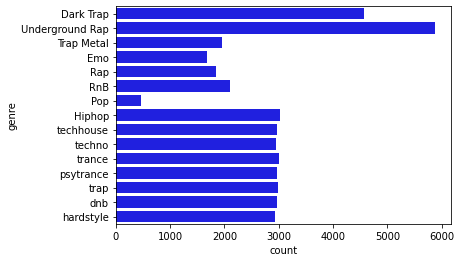

In [3]:
# deal with imbalance problem
data['genre'].value_counts()/len(data) #count genre frequent
sns.countplot(y="genre", data=data, color='blue')

x = data.iloc[:,data.columns != 'genre']
y = data.iloc[:,data.columns == 'genre']

ros = RandomOverSampler()
x_ros,y_ros = ros.fit_resample(x,y)

print(y_ros.value_counts())
# x_ros.value_counts()

In [4]:
# cut data
x_train, x_test, y_train, y_test = train_test_split(x_ros,y_ros,test_size=0.2,random_state=45)

train_x = x_train
test_x = x_test
train_y = y_train
test_y = y_test

fea_train_x = copy.copy(x_train)
fea_test_x = copy.copy(x_test)
fea_train_y = copy.copy(y_train)
fea_test_y = copy.copy(y_test)

# print(x_train)
# print(fea_train_x)
display(fea_train_x.columns)

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature'],
      dtype='object')

In [5]:
# Select imporant features
labelencoder = LabelEncoder()
scaling = StandardScaler()
scaling.fit(train_x)
train_x = pd.DataFrame(scaling.transform(train_x), index=train_x.index, columns=train_x.columns)
test_x = pd.DataFrame(scaling.transform(test_x), index=test_x.index, columns=test_x.columns)

train_y['genre'] = labelencoder.fit_transform(train_y['genre'])
test_y['genre'] = labelencoder.fit_transform(test_y['genre'])
scaled = scaling.fit(train_y)
train_y = pd.DataFrame(scaled.transform(train_y), index=train_y.index, columns=train_y.columns)
test_y = pd.DataFrame(scaled.transform(test_y), index=test_y.index, columns=test_y.columns)

feature_names = ['F{}'.format(i) for i in range(train_x.shape[1])]
train_pool = Pool(train_x,train_y, feature_names=feature_names)
test_pool = Pool(test_x, test_y, feature_names=feature_names)

model = CatBoostRegressor(iterations=1000, random_seed=0,use_best_model=True)
summary = model.select_features(train_pool,
                                eval_set=test_pool,
                                features_for_select='0-11',
                                num_features_to_select=11,
                                steps=3,
                                algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                                shap_calc_type=EShapCalcType.Regular,
                                train_final_model=True,
                                logging_level='Silent',
                                plot=False)
summary

The number of features selection steps (3) is greater than the number of features to eliminate (1). The number of steps was reduced to 1.


{'selected_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'eliminated_features_names': ['F11'],
 'loss_graph': {'main_indices': [0, 1],
  'removed_features_count': [0, 1],
  'loss_values': [0.501900353226855, 0.5009445523501734]},
 'eliminated_features': [11],
 'selected_features_names': ['F0',
  'F1',
  'F2',
  'F3',
  'F4',
  'F5',
  'F6',
  'F7',
  'F8',
  'F9',
  'F10']}

In [6]:
fea_train_x.drop(columns=[ 'time_signature'],axis=1, inplace=True)
fea_test_x.drop(columns=['time_signature'],axis=1, inplace=True)
print(fea_train_x)

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
77632         0.753   0.742    0    -8.202     1       0.0543      0.018800   
5647          0.872   0.599    7    -5.525     1       0.0434      0.066400   
31106         0.559   0.982    8    -4.067     1       0.0561      0.000162   
6298          0.754   0.712    6    -6.610     0       0.2140      0.243000   
76887         0.824   0.863    6    -5.953     0       0.1050      0.083400   
...             ...     ...  ...       ...   ...          ...           ...   
12895         0.416   0.860    7    -3.940     1       0.0480      0.000972   
60960         0.796   0.500    1    -7.210     1       0.4250      0.118000   
6012          0.726   0.769    6    -5.043     1       0.1230      0.029300   
63107         0.743   0.347    1   -11.174     1       0.1210      0.167000   
6558          0.839   0.355   10   -13.986     1       0.1020      0.000700   

       instrumentalness  liveness  valence    tempo

In [7]:
#Feature Normalization

scaling = StandardScaler()

scaling.fit(x_train)
x_train = pd.DataFrame(scaling.transform(x_train), index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(scaling.transform(x_test), index=x_test.index, columns=x_test.columns)

#scaling.fit(fea_train_x)
#fea_train_x = pd.DataFrame(scaling.transform(fea_train_x), index=fea_train_x.index, columns=fea_train_x.columns)
#fea_test_x = pd.DataFrame(scaling.transform(fea_test_x), index=fea_test_x.index, columns=fea_test_x.columns)

In [8]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy', n_estimators=10,random_state=3,n_jobs=2) 
#scores = cross_val_score(forest, x_ros, y_ros, cv=5)
#print(scores)

forest.fit(x_train, y_train)
pred = forest.predict(x_test)
print(pred)
print(y_test)

#print("Accuracy Score =",precision_score(y_test,pred,average='macro'))
    
#print("Confusion Matrix:")
#print(confusion_matrix(y_test, pred))
#cm = confusion_matrix(np.arange(25), np.arange(25))
#disp = ConfusionMatrixDisplay.from_predictions(y_test, pred)
#fig, ax = plt.subplots(figsize=(10,10))
#disp.plot(ax=ax)

#select imporant feature
#forest.fit(fea_train_x, fea_train_y)
#pred_fea = forest.predict(fea_test_x)
#print("Accuracy Score =",precision_score(fea_test_y,pred_fea,average='macro'))

[ 5  5  7 ... 10  5  6]
       genre
63756      5
60918      5
43         0
70036      8
23109     11
...      ...
25230     12
15879      4
30961     10
62401      5
1888       0

[17625 rows x 1 columns]


In [9]:
ans = pd.DataFrame(pred,index=y_test.index)
#print(ans)
#print(y_test)
ans_RF = y_test.merge(ans, how='inner', left_index=True, right_index=True)
print(ans_RF)

ans_RF.to_excel('RF.xlsx', sheet_name='sheet1', index=False)

       genre   0
63756      5   5
60918      5   5
43         0   7
70036      8   8
23109     11  11
...      ...  ..
25230     12  12
15879      4   4
30961     10  10
62401      5   5
1888       0   6

[17625 rows x 2 columns]


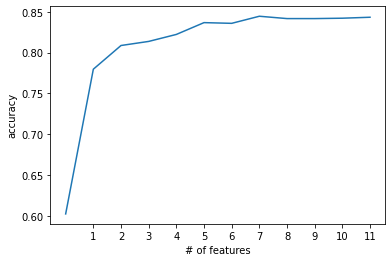

In [10]:
#plot feature from RF
import matplotlib.pyplot as plt

dataRF = [0.602603962539567,0.7796497971751456,0.808638461412683,0.8136327983491678,0.8221767718079973,0.8366198479484652,0.8357513041244076,
         0.84442863811257,0.8415608496208485,0.8415608496208485,0.8420311792021028,0.8432039007146146]
x = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.xticks(x)
plt.plot(dataRF)
plt.xlabel("# of features")
plt.ylabel("accuracy")
plt.show()

In [ ]:
#lineaer SVM
from sklearn.svm import SVC

svm = SVC(kernel='linear',C=1,random_state=42)
#scores = cross_val_score(svm, x_ros, y_ros, cv=3)
#print(scores)

svm.fit(x_train, y_train)
pred = svm.predict(x_test)

print("Accuracy Score =",precision_score(y_test,pred, average='macro'))

print("Confusion Matrix:")
#print(confusion_matrix(y_test, pred))
cm = confusion_matrix(np.arange(25), np.arange(25))
#disp = ConfusionMatrixDisplay.from_predictions(y_test, pred)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

#select imporant feature
#svm.fit(fea_train_x, fea_train_y)
#pred_fea = svm.predict(fea_test_x)
#print("Accuracy Score =",precision_score(fea_test_y,pred_fea,average='macro'))

In [ ]:
ans2 = pd.DataFrame(pred,index=y_test.index)
#print(ans)
#print(y_test)
ans_svm = y_test.merge(ans2, how='inner', left_index=True, right_index=True)
print(ans_RF)

ans_svm.to_excel('svm.xlsx', sheet_name='sheet1', index=False)

In [ ]:
#plot feature from RF
import matplotlib.pyplot as plt

dataSVM = [0.13575341855196738,0.32212191887525166,0.3982776227924527,0.40671574840958596,0.44510147781230885,
        0.4898217948579922,0.4898217948579922,0.5215159891804503,0.547526763561774,0.5569521064820655,
        0.559069322161989,0.566199736292028,0.5592542657007442
       ]
x = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.xticks(x)
plt.plot(dataSVM)
plt.xlabel("# of features")
plt.ylabel("accuracy")
plt.show()

In [ ]:
#read data with 11 features
data11 = pd.read_csv('../input/dataset-of-songs-in-spotify/genres_v2.csv')
data11.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'song_name', 'Unnamed: 0', 'title'],axis=0,inplace=True)
#print(data11)

In [ ]:
scaling = StandardScaler()
scaled = scaling.fit_transform(data11)
scaled_df = pd.DataFrame(scaled,columns=data11.columns)
#print(data11)
print(scaled_df)

In [ ]:
#correct data
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data_cor = pd.read_csv('../input/dataset-of-songs-in-spotify/genres_v2.csv')
#display(data_cor.columns)
data_cor.drop(columns=['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms','time_signature', 'song_name', 'Unnamed: 0', 'title'],axis=1, inplace=True)
data_cor['genre'] = labelencoder.fit_transform(data_cor['genre'])
#print(data_cor)
scaling=StandardScaler()
scaled2=scaling.fit_transform(data_cor)
scaled_df2=pd.DataFrame(scaled2,columns=data_cor.columns)
scaled_df2

In [ ]:
#K-means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3,random_state=0)
kmeans.fit(scaled_df)

kmeans_label = KMeans(n_clusters=15,random_state=0)
kmeans_label.fit(scaled_df2)

print("rand Index:",metrics.rand_score(kmeans_label.labels_, kmeans.labels_))
print("Normalized Mutual Information:",metrics.normalized_mutual_info_score(kmeans_label.labels_,kmeans.labels_))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(kmeans_label.labels_,kmeans.labels_))
print("V-measure:",metrics.v_measure_score(kmeans_label.labels_,kmeans.labels_))
print("Fowlkes-Mallows Scores:",metrics.fowlkes_mallows_score(kmeans_label.labels_,kmeans.labels_))
print("Silhouette Coefficient:",metrics.silhouette_score(scaled_df, kmeans.labels_))

In [ ]:
#Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering

hier = AgglomerativeClustering(n_clusters = 3)
hier.fit(scaled_df)

hier_label = AgglomerativeClustering(n_clusters=15)
hier_label.fit(scaled_df2)

print("rand Index:",metrics.rand_score(hier_label.labels_, hier.labels_))
print("Normalized Mutual Information:",metrics.normalized_mutual_info_score(hier_label.labels_,hier.labels_))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(hier_label.labels_,hier.labels_))
print("V-measure:",metrics.v_measure_score(hier_label.labels_,hier.labels_))
print("Fowlkes-Mallows Scores:",metrics.fowlkes_mallows_score(hier_label.labels_,hier.labels_))
print("Silhouette Coefficient:",metrics.silhouette_score(scaled_df, hier.labels_))

In [ ]:
#DBSCAN
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps = 2, min_samples = 10)
dbs.fit(scaled_df)

dbs_label = DBSCAN(eps = 2, min_samples = 10)
dbs_label.fit(scaled_df2)

print("rand Index:",metrics.rand_score(dbs_label.labels_, dbs.labels_))
print("Normalized Mutual Information:",metrics.normalized_mutual_info_score(dbs_label.labels_,dbs.labels_))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(dbs_label.labels_,dbs.labels_))
print("V-measure:",metrics.v_measure_score(dbs_label.labels_,dbs.labels_))
print("Fowlkes-Mallows Scores:",metrics.fowlkes_mallows_score(dbs_label.labels_,dbs.labels_))
print("Silhouette Coefficient:",metrics.silhouette_score(scaled_df, dbs.labels_))

In [ ]:
#GMM
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = 13).fit(scaled_df)

gmm_label = GaussianMixture(n_components=15).fit(scaled_df2)

print("rand Index:",metrics.rand_score(gmm_label.predict(scaled_df2), gmm.predict(scaled_df)))
print("Normalized Mutual Information:",metrics.normalized_mutual_info_score(gmm_label.predict(scaled_df2),gmm.predict(scaled_df)))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(gmm_label.predict(scaled_df2),gmm.predict(scaled_df)))
print("V-measure:",metrics.v_measure_score(gmm_label.predict(scaled_df2),gmm.predict(scaled_df)))
print("Fowlkes-Mallows Scores:",metrics.fowlkes_mallows_score(gmm_label.predict(scaled_df2),gmm.predict(scaled_df)))
#print("Silhouette Coefficient:",metrics.silhouette_score(scaled_df, gmm.predict(scaled_df)))
print("Silhouette Coefficient: 0.0261791728696776")


In [ ]:
#birch
from sklearn.cluster import Birch

birch = Birch(n_clusters=3)
birch.fit(scaled_df)

birch_label = Birch(n_clusters=15)
birch_label.fit(scaled_df2)

print("rand Index:",metrics.rand_score(birch_label.labels_, birch.labels_))
print("Normalized Mutual Information:",metrics.normalized_mutual_info_score(birch_label.labels_,birch.labels_))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(birch_label.labels_,birch.labels_))
print("V-measure:",metrics.v_measure_score(birch_label.labels_,birch.labels_))
print("Fowlkes-Mallows Scores:",metrics.fowlkes_mallows_score(birch_label.labels_,birch.labels_))
print("Silhouette Coefficient:",metrics.silhouette_score(scaled_df, birch.labels_))
